# Collecting Typical Blobs based on pre-detected cells from multiple sections

In [88]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys, os, time

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [89]:
save_folder_path = '/shared/blob_matching_atlas/'
from xj_utilities import *
fun_create_folder(save_folder_path=save_folder_path)

Folder already exists: /shared/blob_matching_atlas/

In [3]:
stack = 'MD589'
metadata_cache['section_limits'][stack]
patch_size = 448
patch_half_size = patch_size / 2
stride = 112
# Crop images
# 
# crop_0_min = 9000
# crop_0_max = 10500
# crop_1_min = 3000
# crop_1_max = 4500

# Brain stem
crop_0_min = 7000
crop_0_max = 13000
crop_1_min = 3000
crop_1_max = 14000
# Inside
# crop_0_min = 4000
# crop_0_max = 6000
# crop_1_min = 2400
# crop_1_max = 4400

# Whole
# crop_0_min = 0
# crop_1_min = 0
# _, _, crop_1_max, crop_0_max = get_default_gridspec(stack=stack, patch_size=patch_size, stride=stride)
im0max = crop_0_max - crop_0_min
im1max = crop_1_max - crop_1_min

# Options
option_rescale_grayscale = True
option_THimage_save = True;
option_save_image_extension = '.png'

# Process images
option_label_connectivity = 4;

### Load and crop origninal images

In [137]:
metadata_cache['section_limits'][stack]

array([ 92, 370])

In [4]:
# Set examine section number range and download from S3 if not available
section_begin = 152
section_end = 162
img_filename = {}
cell_centroids = {}
cell_numbers = {}
cell_global_coord = {}
secList = range(section_begin, section_end +1 )

for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue           
            
    

rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCentroids.bp


Child returned 0
Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N26-2015.07.30-17.44.37_MD589_3_0078/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_blobCoords.hdf


Child returned 0
1.09 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N26-2015.07.30-17.44.37_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.02 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCentroids.bp


Child returned 0
0.48 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_blobCoords.hdf


Child returned 0
1.10 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC26-2015.07.30-23.01.56_MD589_3_0078_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.03 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCentroids.bp


Child returned 0
0.49 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_1_0079/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_blobCoords.hdf


Child returned 0
1.15 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.09 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCentroids.bp


Child returned 0
0.50 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_blobCoords.hdf


Child returned 0
1.23 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_1_0079_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.04 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCentroids.bp


Child returned 0
0.45 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_2_0080/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_blobCoords.hdf


Child returned 0
1.06 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
1.99 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCentroids.bp


Child returned 0
0.51 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_blobCoords.hdf


Child returned 0
1.24 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_2_0080_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.10 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCentroids.bp


Child returned 0
0.47 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N27-2015.07.30-17.49.06_MD589_3_0081/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_blobCoords.hdf


Child returned 0
1.13 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N27-2015.07.30-17.49.06_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.05 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCentroids.bp


Child returned 0
0.52 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_blobCoords.hdf


Child returned 0
1.25 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC27-2015.07.30-23.06.26_MD589_3_0081_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.12 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCentroids.bp


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_1_0082/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_blobCoords.hdf


Child returned 0
1.30 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.08 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCentroids.bp


Child returned 0
0.53 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_blobCoords.hdf


Child returned 0
1.36 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-IHC28-2015.07.30-23.11.15_MD589_1_0082_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.13 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCentroids.bp && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCentroids.bp /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCentroids.bp


Child returned 0
0.54 seconds.
Child returned 0


rm -rf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCoords.hdf && mkdir -p /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083
aws s3 cp s3://mousebrainatlas-data/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCoords.hdf /shared/CSHL_cells_v2/detected_cells/MD589/MD589-N28-2015.07.30-17.53.43_MD589_2_0083/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_blobCoords.hdf


Child returned 0
1.37 seconds.


rm -rf /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif && mkdir -p /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped
aws s3 cp s3://mousebrainatlas-data/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif /shared/CSHL_data_processed/MD589/MD589_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped/MD589-N28-2015.07.30-17.53.43_MD589_2_0083_lossless_alignedTo_MD589-IHC31-2015.07.30-23.26.22_MD589_1_0091_cropped.tif


Child returned 0
Child returned 0
2.10 seconds.


In [ ]:
# Functionalize loading data
stack = 'MD589'
section_begin, section_end = metadata_cache['section_limits'][stack]
secList = range(section_begin, section_end+1)
# Download all the data for MD589
for tempSec in secList:
    img_filename[tempSec] = DataManager.get_image_filepath(stack=stack, section=tempSec, resol='lossless', version='cropped')
    cell_centroids[tempSec] = load_cell_data('centroid',stack=stack,sec=tempSec)
    cell_numbers[tempSec] = cell_centroids[tempSec].shape[0]
    cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    if os.path.isfile(img_filename[tempSec]):
        sys.stderr.write('Image file is already available. \n')
        continue
    else:
        try:
            download_from_s3(img_filename[tempSec])
        except:
            sys.stderr.write('Download fail. Skip this file...\n')
            secList.remove(tempSec)
            continue   


sec = 152
scan_section_range = 1
sec_load_data_list = range()

In [8]:
# Load image, change RGB images to grayscale image, rescale the grayscale
option_rescale_grayscale = True
option_inverse_color = False
sec = section_begin + 1

im_cropped = {}
im_rescale = {}
for tempSec in secList:
    im_cropped[tempSec] = img_as_ubyte(rgb2gray(imread(img_filename[tempSec])[crop_0_min:crop_0_max,crop_1_min:crop_1_max]))
    if option_rescale_grayscale:
        im_rescale[tempSec] = fun_rescale_grayscale_image(im_cropped[tempSec],invcol=option_inverse_color)


/usr/local/lib/python2.7/dist-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/usr/local/lib/python2.7/dist-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


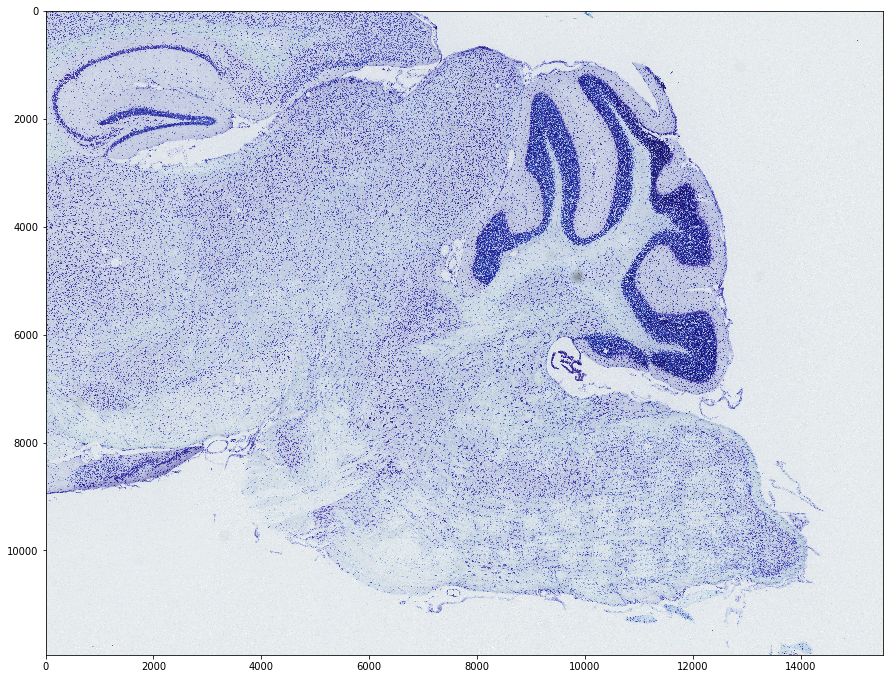

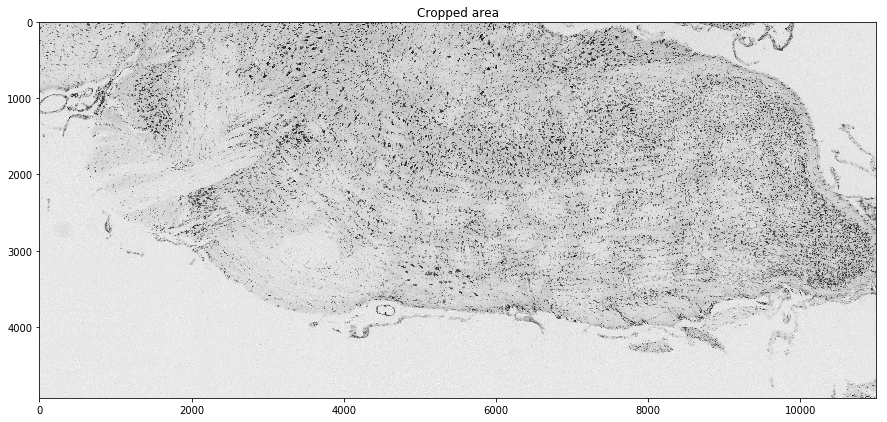

In [12]:
# # Show the entire image
plt.figure(figsize=(15,15))
plt.imshow(imread(img_filename[sec]))
# # Show the cropped image
plt.figure(figsize=(15,15))
plt.imshow(im_cropped[sec],cmap=plt.cm.gray)
plt.title('Cropped area')
           

### Reconstruct labeled image from detected cell dataset

In [9]:
# Construct BW images
oriImL1,oriImL0 = metadata_cache['image_shape'][stack] # The order is annoying....

In [10]:
option_crop = True
option_clear_border = True
option_relabel = True
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
crop_range = (crop_0_min,crop_0_max,crop_1_min,crop_1_max)
for tempSec in secList:
    temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= crop_range, 
                                                                    oriImL0=oriImL0,oriImL1=oriImL1)
    im_label[tempSec] = temp_im_label
    im_BW[tempSec] = temp_im_label>0
    im_blob_prop[tempSec]  = np.array(temp_im_blob_prop)

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}

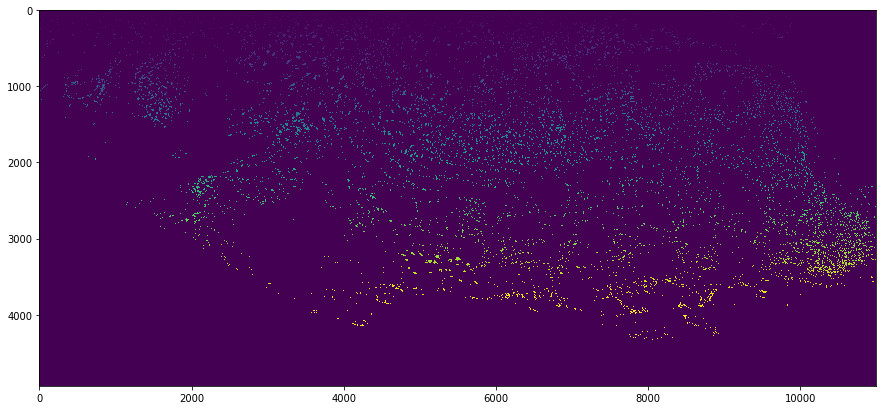

In [199]:
# plt.figure(figsize=(15,15))
# plt.imshow(im_label[sec])

To do list: 
1. Collect typical blobs. Typical in a sense that they match blobs in the corresponding neighboring region in the next section( based on the aligned image).
    - Read images of given sections in a given list as dictionary. Crop the brain stem area
    - Reconstruct labeled blob image
    - Write a function: input list of bolb centroid, vertice coordinate of the polygon, output the bool vector of existence
    - Check if each blob in section is typical or not. If yes, record the blob index, as well as the matched blob index in the nearby section: [sec, blobID, properties, scanSec, blobID, properties, similarity_vector]
    - Collect blobs in 10 consecutive sections, visualize the typical blob in 3D (?)
    

    

# Integrated - blob comparsion

In [126]:
scan_parameters = {}
scan_parameters['scan_section_range'] = 1
scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter']
scan_parameters['prop_for_comparison'] = ['area', 'orientation','moments_hu']
scan_parameters['compare_weight'] = [1 for i in range(len(prop_for_comparison) + 6)]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.8
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['im0max'] = im0max
scan_parameters['im1max'] = im1max

In [13]:
# Parameters
scan_section_range = 1
prop = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter'] # Features for comparison
prop_for_comparison = ['area', 'orientation','moments_hu']
typicalBlobs_dic = {}
matchedBlobs_dic = {}
compare_weight = [1 for i in range(len(prop_for_comparison) + 6)]
compare_weight = np.array(compare_weight)/ float(np.sum(compare_weight))
o_simil_threshold = 0.8
o_scan_size_coeff = 5
o_scan_size = 112
o_fix_scan_size = True

In [15]:
for sec in secList:
    print('Section %d'%sec)
    scan_section = range(sec - scan_section_range, sec + scan_section_range + 1)
    scan_section.remove(sec)
    typical_blobs = []
    matched_paris = []
    for blobID in range(n_blobs[sec]):
        if (blobID % 1000) == 0:
            print('Finished percentage: %f'%(float(blobID)*100 / n_blobs[sec]))
        temp_curr_blob_props = im_blob_prop[sec][blobID]
        tempB1_idx_loc = temp_curr_blob_props['centroid']
        tempB1_orientation = temp_curr_blob_props['orientation']
        tempB1_hu = temp_curr_blob_props['moments_hu']
        tempB1_size = temp_curr_blob_props['area']
        if o_fix_scan_size:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
        else:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)

        #################################
        for tempSec in scan_section:
            if tempSec not in secList:
    #             print('Section %d is not in the load image list.'%tempSec);
                continue
            # Find blobs in the scaned section
            temp_im = fun_crop_images(im_label[tempSec],*temp_next_sec_range_1D, margin=0,im0max=im0max, im1max=im1max)
            tempBlobInsideIndex = np.delete(np.unique(temp_im.flatten()),0,axis=0) - 1
            temp_num_blob = len(tempBlobInsideIndex)
            if temp_num_blob:
                temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                continue


            # Get blob properties
            temp_next_blob_props = {}
            for tempProp in prop:
                temp_prop_value = []
                for blobIndex in range(temp_num_blob):
                    temp_prop_value.append(temp_next_sec_blob_prop[blobIndex][tempProp])
                temp_next_blob_props[tempProp] = temp_prop_value
            temp_next_blob_props['relative_dict'] = []
            for blobIndex in range(temp_num_blob):
                temp_next_blob_props['relative_dict'].append(fun_local_distance(temp_next_sec_blob_prop[blobIndex]['centroid'],local_cloc))

            temp_sim = {}

            for temp_prop in prop_for_comparison:
                    temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop],
                                                             temp_next_blob_props[temp_prop],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

            # Blob comparison


            temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
            temp_compare_result = temp_weighted_sim > o_simil_threshold
            if any(temp_compare_result.tolist()):
                typical_blobs.append([sec, blobID, im_blob_prop[sec][blobID]])
                # list of [section, blobID, blob_properties, scan_section, matched_blob_IDs, matched_blobs_properties, match_blob_similarities]
                matched_paris.append([sec,blobID,im_blob_prop[sec][blobID],tempSec, tempBlobInsideIndex[temp_compare_result], im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],temp_sim_matrix[temp_compare_result,:]])
    typicalBlobs_dic[sec] = typical_blobs
    matchedBlobs_dic[sec] = matched_paris

Section 152
Finished percentage: 0.000000
Finished percentage: 5.701254
Finished percentage: 11.402509
Finished percentage: 17.103763
Finished percentage: 22.805017
Finished percentage: 28.506271
Finished percentage: 34.207526
Finished percentage: 39.908780
Finished percentage: 45.610034
Finished percentage: 51.311288
Finished percentage: 57.012543
Finished percentage: 62.713797
Finished percentage: 68.415051
Finished percentage: 74.116306
Finished percentage: 79.817560
Finished percentage: 85.518814
Finished percentage: 91.220068
Finished percentage: 96.921323
Section 153
Finished percentage: 0.000000
Finished percentage: 6.674676
Finished percentage: 13.349353
Finished percentage: 20.024029
Finished percentage: 26.698705
Finished percentage: 33.373381
Finished percentage: 40.048058
Finished percentage: 46.722734
Finished percentage: 53.397410
Finished percentage: 60.072087
Finished percentage: 66.746763
Finished percentage: 73.421439
Finished percentage: 80.096115
Finished percentage

In [42]:
# fun_reconstruct_labeled_image()
typicalBlobs_vis_dic = {}
for sec in secList:
    temp_typical_blob_in_sec = [typicalBlobs_dic[sec][tempBIdx][2]['coords'] for tempBIdx in range(len(typicalBlobs_dic[sec]))]
    temp_vis_tyblob_in_sec,_,_ = fun_reconstruct_labeled_image(temp_typical_blob_in_sec,oriImL0=im0max,oriImL1=im1max)
    typicalBlobs_vis_dic[sec] = np.array(temp_vis_tyblob_in_sec>0,dtype=np.int16)

In [50]:
typicalBlob_vis_combined = np.sum(np.array(typicalBlobs_vis_dic.values()),axis=0)

In [74]:
display_image(fun_rescale_grayscale_image(typicalBlob_vis_combined))

/shared/MouseBrainAtlasXiang/XJ/tmp.jpg

In [70]:
display_image(fun_rescale_grayscale_image(typicalBlob_vis_combined),filename=save_folder_path + fun_construct_filename(['Typical_Blobs_overlay',stack,'Section',section_begin,'to',section_end])+'.jpg')

/shared/blob_matching_atlas/Typical_Blobs_overlay_MD589_Section_152_to_162.jpg

In [17]:
plot_sec = 152
plot_sec0 = 151
layer_thickness = 20
temp_coord = typicalBlobs_dic[152][0][2]['coords']

In [19]:
temp_coords_set = []
temp_color = []
for plot_sec in secList:
    for tempBlob in typicalBlobs_dic[plot_sec]:
        temp_coord = tempBlob[2]['coords'];
        temp_z = np.ones([len(temp_coord),1],dtype=np.int32) * (plot_sec - plot_sec0)*layer_thickness;
        temp_coord_3D = np.column_stack((temp_coord, temp_z))
        temp_coords_set.append(temp_coord_3D)
        temp_color.append(np.ones([len(temp_coord_3D),1],dtype=np.int32)*(plot_sec - plot_sec0))

In [20]:
temp_coords_set = np.row_stack(tuple(temp_coords_set))
temp_color = np.row_stack(tuple(temp_color))

In [21]:
from mpl_toolkits.mplot3d import Axes3D

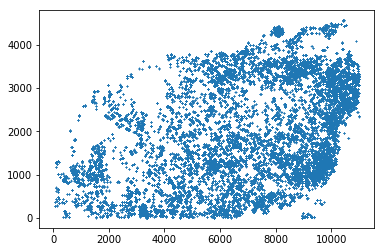

In [29]:
# plt.figure(figsize=(15,15))
plt.scatter(temp_coords_set[:,1],temp_coords_set[:,0],s=0.1)

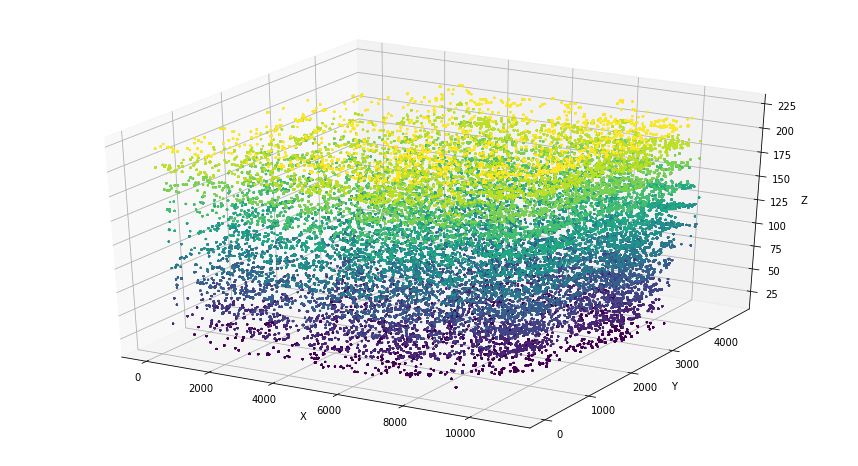

In [22]:
temp_fig = plt.figure(figsize=(15,15*im0max/float(im1max)))
temp_ax = temp_fig.add_subplot(111,projection='3d')
temp_ax.scatter(temp_coords_set[:,1],temp_coords_set[:,0],temp_coords_set[:,2],c=temp_color,s=1)
temp_ax.set_xlabel('X')
temp_ax.set_ylabel('Y')
temp_ax.set_zlabel('Z')
plt.show()

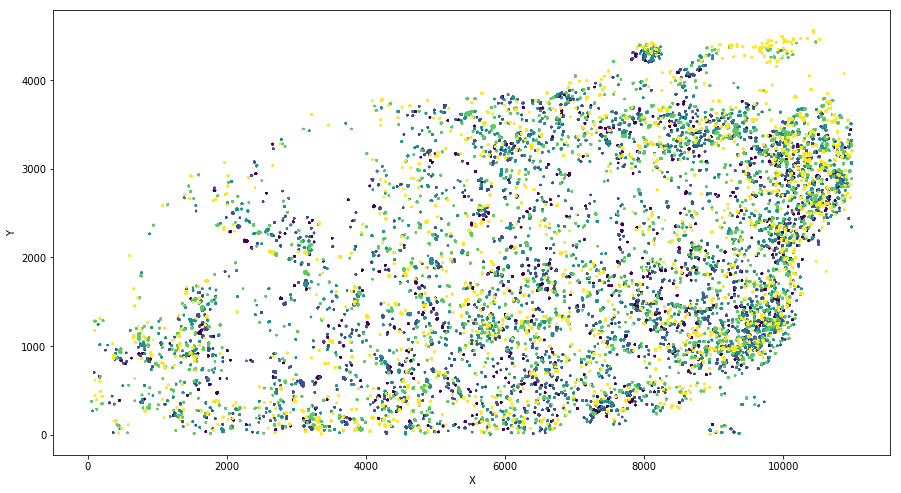

In [31]:
temp_fig = plt.figure(figsize=(15,15*im0max/float(im1max)))
# temp_ax = temp_fig.add_subplot(111,projection='3d')
temp_ax = temp_fig.add_subplot(111)
temp_ax.scatter(temp_coords_set[:,1],temp_coords_set[:,0],c=temp_color,s=1)
temp_ax.set_xlabel('X')
temp_ax.set_ylabel('Y')

# temp_ax.set_zlabel('Z')
plt.show()

In [111]:
o_simil_threshold

0.8

In [109]:
# Number of typical blobs in each section:
[len(set([(item[0],item[1]) for item in typicalBlobs_dic[sec]])) for sec in secList]

[621, 1240, 1367, 1348, 1275, 1353, 1409, 1424, 1641, 1755, 961]

In [110]:
# Percentile 
np.array([len(set([(item[0],item[1]) for item in typicalBlobs_dic[sec]])) for sec in secList],dtype=np.float)/ np.array(n_blobs.values())

array([ 0.03076694,  0.0532646 ,  0.06845611,  0.07685291,  0.08510212,
        0.08192552,  0.07300518,  0.09933729,  0.08347746,  0.11104784,
        0.05195718])

In [161]:
scan_parameters

{'compare_weight': array([ 0.11111111,  0.11111111,  0.11111111,  0.11111111,  0.11111111,
         0.11111111,  0.11111111,  0.11111111,  0.11111111]),
 'im0max': 6000,
 'im1max': 11000,
 'o_fix_scan_size': True,
 'prop': ['centroid',
  'eccentricity',
  'area',
  'orientation',
  'moments_hu',
  'bbox',
  'equivalent_diameter'],
 'prop_for_comparison': ['area', 'orientation', 'moments_hu'],
 'scan_section_range': 1,
 'scan_size': 112,
 'scan_size_coeff': 5,
 'similarity_threshold': 0.8}